<a href="https://colab.research.google.com/github/dirudiez/TFM_DiegoRudiez/blob/main/AutoencoderBasico_Kaggle_256.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Librerías

In [1]:
import PIL
import cv2
import os

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt

## Descarga de Datos

Nos descargamos las imágenes con un ancho de 256 de ancho. Vamos a ir escalando a 64, 128 y 256. Lo haremos con cv2.resize()

### Kaggle

**Descargamos un dataset de kaggle para aumentar el número de imágenes de prueba**

Tiene las siguientes clases:

*   0 - No DR
*   1 - Mild
*   2 - Moderate
*   3 - Severe
*   4 - Proliferative DR


A nosotros nos intersan las de la clase 0. 







In [2]:
! pip install -q kaggle

In [3]:
from google.colab import files

In [4]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"diegorudiezgomez","key":"a97ea3f0837ef30e1012d50ea0d74929"}'}

In [5]:
! mkdir ~/.kaggle

In [6]:
! cp kaggle.json ~/.kaggle/

In [7]:
 ! chmod 600 ~/.kaggle/kaggle.json

**Tras relizar algunas configuraciones descargamos el dataset:**

In [8]:
%%time
! kaggle competitions download -c 'aptos2019-blindness-detection'

100% 9.50G/9.51G [01:17<00:00, 140MB/s]
100% 9.51G/9.51G [01:17<00:00, 131MB/s]
CPU times: user 1.31 s, sys: 238 ms, total: 1.54 s
Wall time: 1min 19s


In [9]:
!unzip -qq aptos2019-blindness-detection.zip -d 'datasetKaggle'

In [10]:
datasetKaggle = 'datasetKaggle'

In [11]:
imgTrain = os.listdir(datasetKaggle + '/train_images')

In [12]:
datasetKaggle + '/train_images/' + imgTrain[0]

'datasetKaggle/train_images/a62e995f167c.png'

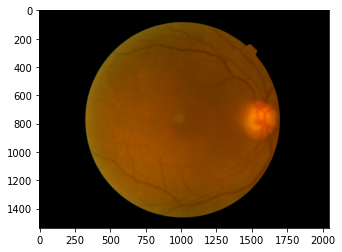

In [13]:
image = cv2.imread(datasetKaggle + '/train_images/' + imgTrain[0])
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)

In [14]:
df_trainKaggle = pd.read_csv(datasetKaggle + '/train.csv')

In [15]:
df_trainKaggle['diagnosis'].value_counts() #1805 imágenes sanas

0    1805
2     999
1     370
4     295
3     193
Name: diagnosis, dtype: int64

In [16]:
df_trainKaggle.head(5)

,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0


### Reto

**Ahora las del reto que hemos utilizado siempre.**

In [17]:
# !wget https://www.dropbox.com/s/o1eaoae59qgdo4i/Training_Set_Pre.zip?dl=0 --no-verbose -O train.zip
# !wget https://www.dropbox.com/s/5od5cac9xhxlcwu/Test_Set_Pre.zip?dl=0 --no-verbose -O test.zip
# !wget https://www.dropbox.com/s/gjz445xm4oddfus/Evaluation_Set_Pre.zip?dl=0 --no-verbose -O val.zip

In [18]:
# !rm -rvf Training_Set_Pre
# !unzip -qq train.zip #-qq no verbose
# !unzip -qq test.zip
# !unzip -qq val.zip

Descargamos el dataset sin procesar, para aplicar el mismo a los dos datsets

In [19]:
!wget https://www.dropbox.com/s/1isaa8xrrv0x6n4/datasetComprimido.zip?dl=0 --no-verbose -O datasetComp.zip

2022-06-27 15:58:30 URL:https://uc73eaa79b48066eb25e45174dc1.dl.dropboxusercontent.com/cd/0/inline2/BoC6aX3sRCy8kD72b4vjYwvXS9RdpiRCjMtyvutqARBapi0-MpOIV7F8eN9Qsq6xhR7nJh622_uCrrxNyFoLDqXfSa1tLrpzINwkW1OlEI6d43g5GuAN2-TVZHijwAT9w8KFak4j9re7BnheQQRojnIPKRKiQdODOitIpLfHeoreuOp29WKr3ojte_CO-jElUDG3fF6TQyxWVT6lao9Da8-uvM8r0W83vmQ5P43OoaQVG2ymNRyEuQ_zK4KGBT8WGxrVDS1ECkQ02LnR-oyEfuTPP8idRshheEbdhAMmMSVJU6NNBeN0cgugDZrBNCRyMziGeFks4Z0q7atwFFRZ4PwH_E879FRISfqb0mMraZ75KxZsCR4mK8ea5DBUUD46rVhuyfLKboqiBrW513zhHnDhGgTVCk1GQjx_7iizcCvxZw/file [144922725/144922725] -> "datasetComp.zip" [1]


In [20]:
!unzip -qq datasetComp.zip

In [21]:
# trainPath = 'Training_Set_Pre/'
# testPath  = 'Test_Set_Pre/'
# valPath  =  'Evaluation_Set_Pre/'

In [22]:
trainPath = 'Training_Set_C/'
testPath  = 'Test_Set_C/'
valPath  =  'Evaluation_Set_C/'

## Preparación de Datos

In [160]:
IMG_SIZE = 256

### Funciones de procesado

In [161]:
def crop_image_from_gray(img,tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
    #         print(img1.shape,img2.shape,img3.shape)
            img = np.stack([img1,img2,img3],axis=-1)
    #         print(img.shape)
        return img

def load_ben_color(path, sigmaX=10):
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = crop_image_from_gray(image)
    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
    image=cv2.addWeighted(image,4, cv2.GaussianBlur(image , (0,0) , sigmaX) ,-4 ,128)
        
    return image

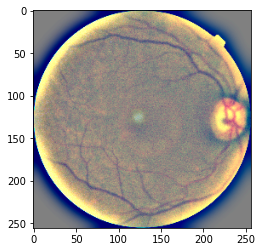

In [162]:
img = load_ben_color(datasetKaggle + '/train_images/' + imgTrain[0], 10)
plt.imshow(img)

### Datos Kaggle

In [163]:
import shutil

def getNpArrayKaggle(df, pathO):
  normal, enfermedad = [], []
  for id, enf in zip(df['id_code'], df['diagnosis']):
    image = load_ben_color(pathO + '/' + str(id) + '.png', sigmaX=30)
    if(int(enf)==0):
      normal.append(np.asarray(image))
    # else:
    #   enfermedad.append(np.asarray(image))
  return np.array(normal), np.array(enfermedad)

In [164]:
normalKaggle, enfermedadKaggle = getNpArrayKaggle(df_trainKaggle, datasetKaggle + '/train_images')

In [165]:
normalKaggle.shape

(1805, 256, 256, 3)

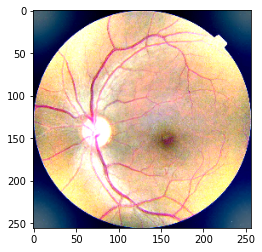

In [166]:
plt.imshow(normalKaggle[0])

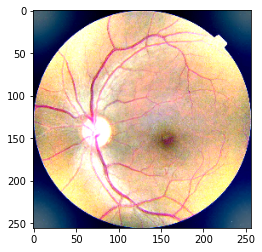

In [167]:
plt.imshow(normalKaggle[0])

### Datos Reto (el mismo de siempre)


In [168]:
import shutil

def getNpArray(df, pathO):
  normal, enfermedad = [], []
  for id, enf in zip(df['ID'], df['Disease_Risk']):
    image = load_ben_color(pathO + '/' + str(id) + '.png', sigmaX=30)
    if(int(enf)==0):
      normal.append(np.asarray(image))
    else:
      enfermedad.append(np.asarray(image))
  return np.array(normal), np.array(enfermedad)

In [169]:
df_train = pd.read_csv(trainPath + '/train.csv')
df_test = pd.read_csv(testPath + '/test.csv')
df_val = pd.read_csv(valPath + '/val.csv')

In [170]:
normalTrain, enfermedadTrain = getNpArray(df_train, trainPath + 'Training/')
normalTest, enfermedadTest = getNpArray(df_test, testPath + 'Test/')
normalVal, enfermedadVal = getNpArray(df_val, valPath + 'Validation/')

In [171]:
normalTrain.shape

(401, 256, 256, 3)

In [172]:
normalTest.shape

(134, 256, 256, 3)

Ya la tenemos reescalada a la medida deseada:

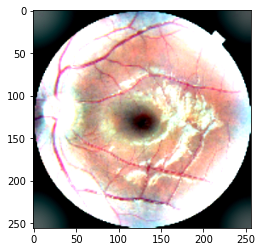

In [173]:
plt.imshow(normalTrain[0])

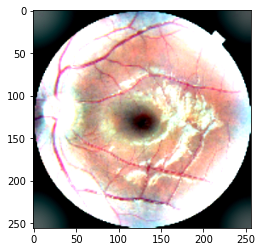

In [174]:
plt.imshow(normalTrain[0])

In [175]:
normalTrain = np.concatenate([normalTrain, normalKaggle])

In [176]:
normalTrain.shape

(2206, 256, 256, 3)

Ahora nos queda normalizar los datos

In [177]:
normalTrain = normalTrain.astype('float32') / 255.
enfermedadTrain = enfermedadTrain.astype('float32') / 255.

normalVal = normalVal.astype('float32') / 255.
enfermedadVal = enfermedadVal.astype('float32') / 255.

normalTest = normalTest.astype('float32') / 255.
enfermedadTest = enfermedadTest.astype('float32') / 255.

## Autoencoder Basico

In [178]:
input_img = layers.Input(shape=(IMG_SIZE,IMG_SIZE,3))

### Encoder

In [179]:
# Capa convolucional con 32 filtros de tamaño 3x3 seguida de una función de activación relu y aplicando padding
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
# Capa de max pooling con filtro de tamaño 2x2 y aplicando padding
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

### Decoder

In [180]:
# Capa convolucional con 32 filtros de tamaño 3x3 seguida de una función de activación relu y aplicando padding
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
 # Capa de upsampling con filtro de tamaño 2x2 y aplicando padding
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

In [181]:
autoencoder = keras.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [182]:
autoencoder.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d_20 (Conv2D)          (None, 256, 256, 32)      896       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 128, 128, 32)     0         
 2D)                                                             
                                                                 
 conv2d_21 (Conv2D)          (None, 128, 128, 32)      9248      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 conv2d_22 (Conv2D)          (None, 64, 64, 32)        9248

### Entrenamiento

In [ ]:
autoencoder.fit(normalTrain, normalTrain,
                epochs=50,
                batch_size=128,
                validation_data=(normalVal, normalVal))

### Pruebas

In [ ]:
decoded_imgs = autoencoder.predict(normalTest)

n = 10
plt.figure(figsize=(20, 4))
for i in range(1,n):
    ax = plt.subplot(2, n, i)
    plt.imshow(normalTest[i].reshape(IMG_SIZE, IMG_SIZE,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(IMG_SIZE, IMG_SIZE,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [ ]:
plt.imshow(decoded_imgs[0])

### Evaluación

In [ ]:
from google.colab.patches import cv2_imshow

# make predictions on our image data and initialize our list of
# reconstruction errors

def test(autoencoder, data):
  decoded = autoencoder.predict(data)
  errors = []
  for (image, recon) in zip(data, decoded):
    mse = np.mean((image - recon) ** 2)
    errors.append(mse)
  thresh = np.quantile(errors, 0.999)
  idxs = np.where(np.array(errors) >= thresh)[0]
  return len(data)-len(idxs), len(idxs)

In [ ]:
def calcularMetricas(TN, FP, FN ,TP):
  print("Accuracy:  ", ((TP + TN)/(TP + TN + FP + FN)))
  recall = (TP/(TP + FN))
  print("Recall :   ", recall)
  precision = (TP/(TP + FP))
  print("Precisión: ", precision)
  print("F1-Score:  ", (2 * precision * recall)/(precision + recall))

In [ ]:
TN, FP = test(autoencoder, normalTest) #TN y FP
FN, TP = test(autoencoder, enfermedadTest) #FN y TP
calcularMetricas(TN, FP, FN ,TP)

In [ ]:
from google.colab.patches import cv2_imshow

# make predictions on our image data and initialize our list of
# reconstruction errors
decoded = autoencoder.predict(enfermedadTest)
errors = []
# loop over all original images and their corresponding
# reconstructions
for (image, recon) in zip(enfermedadTest, decoded):
	# compute the mean squared error between the ground-truth image
	# and the reconstructed image, then add it to our list of errors
	mse = np.mean((image - recon) ** 2)
	errors.append(mse)
# compute the q-th quantile of the errors which serves as our
# threshold to identify anomalies -- any data point that our model
# reconstructed with > threshold error will be marked as an outlier
thresh = np.quantile(errors, 0.999)
idxs = np.where(np.array(errors) >= thresh)[0]
print("[INFO] mse threshold: {}".format(thresh))
print("[INFO] {} outliers found".format(len(idxs)))
# initialize the outputs array
outputs = None
# loop over the indexes of images with a high mean squared error term
for i in idxs:
	# grab the original image and reconstructed image
	original = (enfermedadTest[i] * 255).astype("uint8")
	recon = (decoded[i] * 255).astype("uint8")
	# stack the original and reconstructed image side-by-side
	output = np.hstack([original, recon])
	# if the outputs array is empty, initialize it as the current
	# side-by-side image display
	if outputs is None:
		outputs = output
	# otherwise, vertically stack the outputs
	else:
		outputs = np.vstack([outputs, output])
# show the output visualization
cv2_imshow(outputs)
cv2.waitKey(0)

## Otra arquitectura diferente

https://medium.com/analytics-vidhya/image-anomaly-detection-using-autoencoders-ae937c7fd2d1

In [ ]:
inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3), name='input_layer')
# Conv Block 1 -> BatchNorm->leaky Relu
encoded = tf.keras.layers.Conv2D(32, kernel_size=3, strides= 1, padding='same', name='conv_1')(inputs)
encoded = tf.keras.layers.BatchNormalization(name='batchnorm_1')(encoded)
encoded = tf.keras.layers.LeakyReLU(name='leaky_relu_1')(encoded)
# Conv Block 2 -> BatchNorm->leaky Relu
encoded = tf.keras.layers.Conv2D(64, kernel_size=3, strides= 2, padding='same', name='conv_2')(encoded)
encoded = tf.keras.layers.BatchNormalization(name='batchnorm_2')(encoded)
encoded = tf.keras.layers.LeakyReLU(name='leaky_relu_2')(encoded)
# Conv Block 3 -> BatchNorm->leaky Relu
encoded = tf.keras.layers.Conv2D(64, kernel_size=3, strides=2, padding='same', name='conv_3')(encoded)
encoded = tf.keras.layers.BatchNormalization(name='batchnorm_3')(encoded)
encoded = tf.keras.layers.LeakyReLU(name='leaky_relu_3')(encoded)
#Decoder
# DeConv Block 1-> BatchNorm->leaky Relu
decoded = tf.keras.layers.Conv2DTranspose(64, 3, strides= 1, padding='same',name='conv_transpose_1')(encoded)
decoded = tf.keras.layers.BatchNormalization(name='batchnorm_4')(decoded)
decoded = tf.keras.layers.LeakyReLU(name='leaky_relu_4')(decoded)
# DeConv Block 2-> BatchNorm->leaky Relu
decoded = tf.keras.layers.Conv2DTranspose(64, 3, strides= 2, padding='same', name='conv_transpose_2')(decoded)
decoded = tf.keras.layers.BatchNormalization(name='batchnorm_5')(decoded)
decoded = tf.keras.layers.LeakyReLU(name='leaky_relu_5')(decoded)
# DeConv Block 3-> BatchNorm->leaky Relu
decoded = tf.keras.layers.Conv2DTranspose(32, 3, 2, padding='same', name='conv_transpose_3')(decoded)
decoded = tf.keras.layers.BatchNormalization(name='batchnorm_6')(decoded)
decoded = tf.keras.layers.LeakyReLU(name='leaky_relu_6')(decoded)
# output
outputs = tf.keras.layers.Conv2DTranspose(3, 3, 1,padding='same', activation='sigmoid', name='conv_transpose_4')(decoded)

In [ ]:
autoencoder = tf.keras.Model(inputs, outputs)
optimizer = tf.keras.optimizers.Adam(lr = 0.0005)
autoencoder.compile(optimizer=optimizer, loss='binary_crossentropy')

In [ ]:
autoencoder.summary()

In [ ]:
hist=autoencoder.fit(normalTrain, normalTrain,
                epochs=50,
                batch_size=128,
                shuffle=True,
                validation_data=(normalVal, normalVal)
                )

In [ ]:
TN, FP = test(autoencoder, normalTest) #TN y FP
FN, TP = test(autoencoder, enfermedadTest) #FN y TP
calcularMetricas(TN, FP, FN ,TP)

In [ ]:
predicts = autoencoder.predict(normalTest)

In [ ]:
plt.imshow(predicts[6])

In [ ]:
predicts = autoencoder.predict(enfermedadTest)

In [ ]:
plt.imshow(predicts[70])

## Diferente Arquitectura

https://towardsdatascience.com/auto-encoder-what-is-it-and-what-is-it-used-for-part-1-3e5c6f017726

In [ ]:
import numpy as np
from tensorflow import keras

import keras
from keras.datasets import mnist
from keras.models import Sequential, Model
from keras.layers import Dense, Input
from keras import optimizers
from tensorflow.keras.optimizers import Adam

In [ ]:
autoencoder = Sequential()
autoencoder.add(Dense(3, activation='elu', input_shape=(IMG_SIZE,IMG_SIZE,3)))
autoencoder.add(Dense(64,  activation='elu'))
autoencoder.add(Dense(10,    activation='linear', name="bottleneck"))
autoencoder.add(Dense(64,  activation='elu'))
autoencoder.add(Dense(128,  activation='elu'))
autoencoder.add(Dense(3,  activation='sigmoid'))
autoencoder.compile(loss='mean_squared_error', optimizer = Adam())

trained_model = autoencoder.fit(
    normalTrain, normalTrain, 
    batch_size=1024, 
    epochs=50, 
    validation_data=(normalVal, normalVal))

In [ ]:
encoder = Model(autoencoder.input, autoencoder.get_layer('bottleneck').output)
encoded_data = encoder.predict(normalTrain)  # bottleneck representation
decoded_output = autoencoder.predict(normalTrain)        # reconstruction
encoding_dim = 10

# return the decoder
encoded_input = Input(shape=(encoding_dim,))
decoder = autoencoder.layers[-3](encoded_input)
decoder = autoencoder.layers[-2](decoder)
decoder = autoencoder.layers[-1](decoder)
decoder = Model(encoded_input, decoder)

In [ ]:
TN, FP = test(autoencoder, normalTest) #TN y FP
FN, TP = test(autoencoder, enfermedadTest) #FN y TP
calcularMetricas(TN, FP, FN ,TP)

In [ ]:
predicts = autoencoder.predict(normalTest)

In [ ]:
plt.imshow(predicts[4])

In [ ]:
predicts = autoencoder.predict(enfermedadTest)

In [ ]:
plt.imshow(predicts[4])

## Otra alternativa

In [ ]:
model = keras.Sequential(
    [
        layers.Input(shape=(normalTrain.shape[1], normalTrain.shape[2])),
        layers.Conv1D(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1D(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Conv1DTranspose(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1DTranspose(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Conv1DTranspose(filters=64, kernel_size=7, padding="same"),
    ]
)
model.compile(optimizer=Adam(learning_rate=0.001), loss="mse")
model.summary()

In [ ]:
model.fit(
    normalTrain,
    normalTrain,
    epochs=50,
    batch_size=128,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
    ],
)